In [2]:
!uv pip install ultralytics

Using Python 3.12.7 environment at: G:\zer0ken\ms-ai-school\.venv
Audited 1 package in 160ms


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

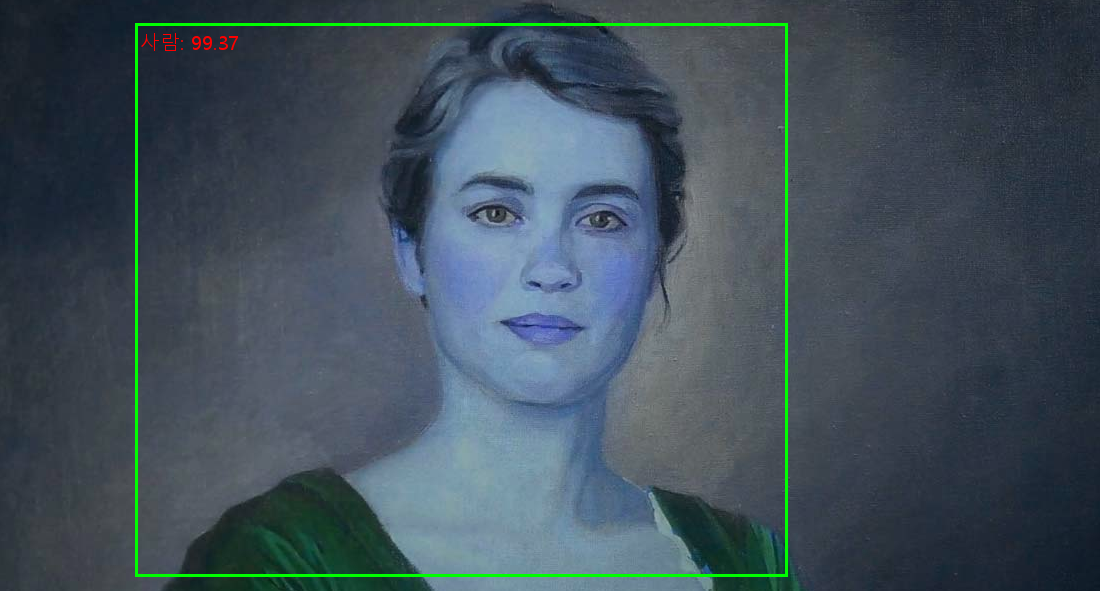

In [4]:
import cv2
import numpy as np
from PIL import ImageDraw, Image, ImageFont
from ultralytics import YOLO

weight_path = 'resources/yolov3.weights'
config_path = 'resources/yolov3.cfg'
names_path = 'resources/coco_korean.names'

model = YOLO('resources/yolov8n.pt')
print(model)

with open(names_path, mode='r', encoding='utf-8') as f:
    labels = f.read().strip().splitlines()

net = cv2.dnn.readNet(weight_path, config_path)

try:
    font = ImageFont.truetype("malgun.ttf", size=20)  # Windows의 맑은 고딕 폰트
except IOError:
    font = ImageFont.load_default()  # 폰트를 찾을 수 없을 경우 기본 폰트 사용


def detect_objects(image):
    bbox_image = Image.fromarray(image.copy())
    draw = ImageDraw.Draw(bbox_image)

    height, width = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    layer_name_list = net.getLayerNames()
    output_layer_list = [layer_name_list[i - 1] for i in net.getUnconnectedOutLayers()]

    results = net.forward(output_layer_list)
    bbox_list = []
    confidence_list = []
    index_list = []

    for result in results:
        for detection in result:
            scores = detection[5:]
            class_index = np.argmax(scores)
            confidence = scores[class_index]

            if confidence > 0:
                bbox = detection[:4] * np.array([width, height, width, height])
                bbox_list.append(bbox)
                confidence_list.append(confidence)
                index_list.append(class_index)

    indices = cv2.dnn.NMSBoxes(bbox_list, confidence_list, 0.5, 0.4)
    
    for i in indices:
        center_x, center_y, w, h = bbox_list[i].astype('int')
        
        if w < 0 or h < 0:
            continue
        
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)

        if x < 0:
            x = 0
        if y < 0:
            y = 0
            
        draw.rectangle((x, y, x + w, y + h), outline=(0, 255, 0), width=3)
        draw.text((x + 5, y + 5), '{0}: {1:.2f}'.format(labels[index_list[i]], confidence_list[i] * 100), 
                    fill=(255, 0, 0), font=font)

    return bbox_image


detect_objects(cv2.imread(r'G:\\zer0ken\\ms-ai-school\\ai-vision\\resources\\crop.png'))

In [ ]:
import io
import base64
import requests

OPENAI_ENDPOINT = "https://fimtrus-openai3.openai.azure.com"    
OPENAI_API_KEY = "***"
DEPLOYMENT_NAME = "gpt-4o"
 
 
def request_gpt(image_array):
    endpoint = "{}/openai/deployments/{}/chat/completions?api-version=2025-01-01-preview".format(OPENAI_ENDPOINT, DEPLOYMENT_NAME)
    headers = {
        "Content-Type": "application/json",
        "api-key": OPENAI_API_KEY
    }
 
    image = Image.fromarray(image_array)
    buffered_io = io.BytesIO()
    image.save(buffered_io, format="png")
    base64_image = base64.b64encode(buffered_io.getvalue()).decode("utf-8")
 
    message_list = []
 
    message_list.append({
        "role": "system",
        "content": [{
            "type": "text",
            "text": """
                너는 사진 속에서 감지된 물체를 분석하는 AI 음성 도우미야.
                소리내서 읽을 수 있는 형식으로 답변을 생성해.
                한국어로만 응답해.
                """
        }]
    })
 
    message_list.append({
        "role": "user",
        "content": [{
            "type": "text",
            "text": """
                이 사진에서 감지된 물체에 대해 감지확률과 함께 자세히 설명해.
                반드시 감지된 물체, 바운딩 박스 안에 있는 물체에 대해서만 설명해.
                """
        }, {
            "type": "image_url",
            "image_url": {
                "url": "data:image/png;base64,{}".format(base64_image),
                "caption": "물체 감지 결과"
            }
        }]
    })
 
    body = {
        "messages": message_list,
        "temperature": 0.7,
        "top_p": 0.95,
        "max_tokens": 16000,
    }
 
    response = requests.post(endpoint, headers=headers, json=body)
 
    if response.status_code == 200:
        response_json = response.json()
        content = response_json["choices"][0]["message"]["content"]
    else:
        content = response.text
 
    return content


request_gpt(cv2.imread(r'G:\\zer0ken\\ms-ai-school\\ai-vision\\resources\\crop.png'))

'이 사진에서 감지된 물체는 녹색 드레스입니다. 드레스는 상반신 부분을 덮고 있으며, 주름과 빛의 반사로 인해 질감이 표현되어 있습니다. 색상은 짙은 녹색으로, 섬세한 붓질이 느껴지는 회화적인 스타일로 표현되었습니다. 감지 확률은 약 95%로 매우 높은 신뢰도를 보입니다.'

In [ ]:
SPEECH_ENDPOINT = "https://eastus.tts.speech.microsoft.com/cognitiveservices/v1"
SPEECH_API_KEY = "***"


def request_tts(text):
    endpoint = SPEECH_ENDPOINT
    headers = {
        'Ocp-Apim-Subscription-Key': SPEECH_API_KEY,
        'Content-Type': 'application/ssml+xml',
        'X-Microsoft-OutputFormat': 'riff-24khz-16bit-mono-pcm'
    }
    body = f"""
    <speak version='1.0' xml:lang='ko-KR'>
        <voice name='ko-KR-JiMinNeural'>
            <prosody rate='20%'>
                {text}
            </prosody>
        </voice>
    </speak>
    """
    
    response = requests.post(endpoint, headers=headers, data=body)
    if response.status_code == 200:
        file_name = 'resources/stt.wav'
        
        with open(file_name, 'wb') as f:
            f.write(response.content)
        
        return file_name


request_tts('안녕하세요')

'resources/stt.wav'

In [53]:
import re
import gradio as gr


def passthrough(image):
    return image


def add_user_request(image, history):
    if image is None:
        return history
    
    history.append({'role': 'user', 'content': gr.Image(label='감지화면', value=image)})
    return history


def add_gpt_response(image, history):
    if image is None:
        return history
    
    response = request_gpt(image)
    history.append({'role': 'assistant', 'content': response})
    return history


def set_stt(image, history):
    if image is None:
        return None
    
    text = history[-1]['content']
    clean_text = re.sub(r'[^가-힣a-zA-Z\s%,\.\d]', '', text)
    return request_tts(clean_text)


with gr.Blocks() as demo:
    gr.Markdown('# 💠 객체 검출 및 분석')
    with gr.Row():
        webcam_image = gr.Image(label="카메라", sources="webcam", streaming=True, mirror_webcam=False)
        bbox_image = gr.Image(label="검출 이미지", streaming=True, interactive=False)
    
    request_button = gr.Button('GPT에게 보내기')

    chatbot = gr.Chatbot(label='GPT', type='messages')
    stt_audio = gr.Audio(label='GPT', interactive=False, autoplay=True)

    webcam_image.stream(detect_objects, inputs=[webcam_image], outputs=[bbox_image])
    request_button.click(
        add_user_request, inputs=[bbox_image, chatbot], outputs=[chatbot]
    ).then(
        add_gpt_response, inputs=[bbox_image, chatbot], outputs=[chatbot]
    ).then(
        set_stt, inputs=[bbox_image, chatbot], outputs=[stt_audio]
    )
    
    
demo.launch()

* Running on local URL:  http://127.0.0.1:7890

To create a public link, set `share=True` in `launch()`.
